In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import os
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2


In [3]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/README.dataset.txt  
  inflating: dataset/README.roboflow.txt  
   creating: dataset/test/
   creating: dataset/test/images/
  inflating: dataset/test/images/12106_png.rf.543facc564fb4bd2d7e153dfdb1b5085.jpg  
  inflating: dataset/test/images/12107_png.rf.c9f665d85eba1e14c991ea2096237fcc.jpg  
  inflating: dataset/test/images/12112_png.rf.532a771b73b6bf88a4c07790bebaad6b.jpg  
  inflating: dataset/test/images/12116_png.rf.8b4c8d5d388ef13804d5c93224eb1243.jpg  
  inflating: dataset/test/images/12122_png.rf.308fca91f4eaa5f2c052c99439fe0501.jpg  
  inflating: dataset/test/images/12125_png.rf.1eb5e06e6c235b18b03a34ecf3be2b9a.jpg  
  inflating: dataset/test/images/12136_png.rf.8e3fb5269a4c73eeeddc8e2aeb67a492.jpg  
  inflating: dataset/test/images/12151_png.rf.b857b4d481e0b7bcabd072bc2e41f352.jpg  
  inflating: dataset/test/images/12165_png.rf.4a8d3d35cb858401b50277867a8ccf85.jpg  
  inflating: dataset/test/images/12180_png.rf

In [11]:
def load_dataframe(csv_path, img_dir):
    df = pd.read_csv(csv_path)
    df['filename'] = df['filename'].apply(lambda x: os.path.join(img_dir, x))
    return df



In [12]:
train_df = load_dataframe('dataset/train/labels.csv', 'dataset/train/images')
valid_df = load_dataframe('dataset/valid/labels.csv', 'dataset/valid/images')
test_df  = load_dataframe('dataset/test/labels.csv', 'dataset/test/images')

# pastikan formatnya benar
print(train_df.head())


                                            filename  house  person  tree
0  dataset/train/images/8818_png.rf.24f1b39f3154c...      1       0     0
1  dataset/train/images/8843_png.rf.467893910cecf...      1       0     0
2  dataset/train/images/12092_png.rf.1db4405ebd73...      0       1     0
3  dataset/train/images/8858_png.rf.9c9abf2fb25b2...      1       0     0
4  dataset/train/images/12233_png.rf.90136be5b53a...      0       1     0


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)


In [25]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col=['house', 'person', 'tree'],
    target_size=(160, 160),
    class_mode='raw',
    batch_size=32,
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col=['house', 'person', 'tree'],
    target_size=(160, 160),
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col=['house', 'person', 'tree'],
    target_size=(160, 160),
    class_mode='raw',
    batch_size=32,
    shuffle=False
)


Found 253 validated image filenames.
Found 73 validated image filenames.
Found 36 validated image filenames.


In [27]:

base_model = MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Bekukan fitur awal

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15
)



Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4310 - loss: 1.8246 - val_accuracy: 0.6164 - val_loss: 1.0646
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7442 - loss: 1.0888 - val_accuracy: 0.8767 - val_loss: 0.8048
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6712 - loss: 1.7012 - val_accuracy: 0.8219 - val_loss: 0.8962
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6711 - loss: 2.2024 - val_accuracy: 0.8356 - val_loss: 0.9713
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7470 - loss: 2.2891 - val_accuracy: 0.8082 - val_loss: 1.2785
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6892 - loss: 3.6291 - val_accuracy: 0.8767 - val_loss: 1.0211
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6655 - loss: 4.2458 - val_accuracy: 0.8630 - val_loss: 1.1613
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7247 - loss: 4.0977 - val_accuracy: 0.8493 - val_loss: 1.5468
Epoch 9/15

In [29]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

y_true = np.argmax(test_generator.labels, axis=1)
y_pred = np.argmax(model.predict(test_generator), axis=1)

print(classification_report(y_true, y_pred, target_names=['house','person','tree']))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.7500 - loss: 2.5708
Test Accuracy: 75.00%
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
              precision    recall  f1-score   support

       house       1.00      0.58      0.74        12
      person       0.67      1.00      0.80        18
        tree       1.00      0.33      0.50         6

    accuracy                           0.75        36
   macro avg       0.89      0.64      0.68        36
weighted avg       0.83      0.75      0.73        36



In [31]:
base_model.trainable = True
for layer in base_model.layers[:100]:  # Bekukan 100 layer pertama
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # learning rate kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5645 - loss: 13.4819 - val_accuracy: 0.8767 - val_loss: 2.9058
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6374 - loss: 9.1143 - val_accuracy: 0.8630 - val_loss: 3.0001
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5954 - loss: 14.7217 - val_accuracy: 0.8493 - val_loss: 3.1051
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6086 - loss: 14.6321 - val_accuracy: 0.8493 - val_loss: 3.2217
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6448 - loss: 11.8591 - val_accuracy: 0.8493 - val_loss: 3.3261
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6032 - loss: 13.5449 - val_accuracy: 0.8630 - val_loss: 3.4301
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6275 - loss: 13.5852 - val_accuracy: 0.8630 - val_loss: 3.5519
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6334 - loss: 14.5933 - val_accuracy: 0.8630 - val_loss: 3.6710
E

In [33]:
# Simpan model ke file .h5
model.save("handwriting_model.h5")

print("Model berhasil disimpan sebagai handwriting_model.h5")


Model berhasil disimpan sebagai handwriting_model.h5


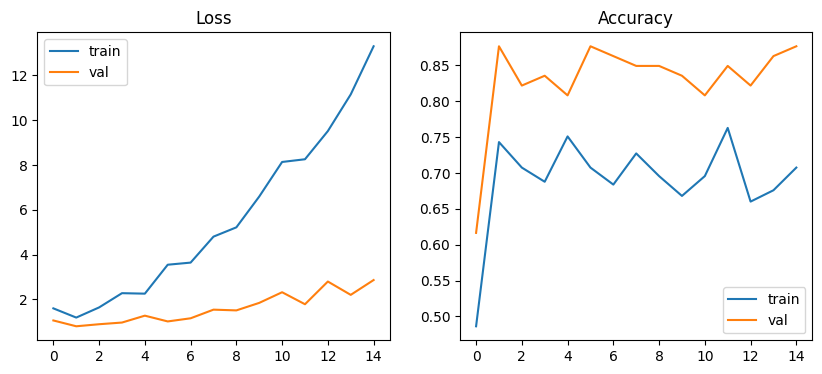

In [32]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.show()
